In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow import keras
# from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
import random
import sys
sys.path.append('../')
from modules import utils
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
SEED = 84
random.seed(SEED)
np.random.seed(SEED)
tf.set_random_seed(SEED)
tf.compat.v1.set_random_seed(SEED)

In [3]:
# def scale_data(X):
# #     X = X.replace(-1, np.nan)
#     scaler = MinMaxScaler()
#     X_scaled = X.copy()
#     X_scaled[:, 0] = scaler.fit_transform(X[:, 0].reshape(-1, 1)).flatten()
#     return X_scaled

#### The training data

In [4]:
# train_df = pd.read_csv('../data/train_set_basic.csv')
train_df = pd.read_csv('../data/train_set_noisiness_0.2_missingness_0.3.csv')
train_df = train_df.fillna(-1)
train_df.head()

,hemoglobin,ferritin,ret_count,segmented_neutrophils,tibc,mcv,serum_iron,rbc,gender,creatinine,cholestrol,copper,ethanol,folate,glucose,hematocrit,tsat,label
0,12.570316,461.686352,-1.000000,2.195594,274.677370,98.593975,-1.0,3.824874,1,-1.000000,-1.000000,-1.0,-1.000000,-1.0,-1.000000,37.710949,-1.000000,5.0
1,6.025877,65.947255,5.269617,-1.000000,-1.000000,78.152338,-1.0,2.313127,0,-1.000000,-1.000000,-1.0,-1.000000,-1.0,-1.000000,-1.000000,-1.000000,7.0
2,7.971342,-1.000000,3.031102,0.000000,391.557192,102.908562,-1.0,2.323813,1,1.750675,78.906129,-1.0,-1.000000,-1.0,-1.000000,23.914025,-1.000000,2.0
3,8.648926,395.552568,-1.000000,-1.000000,-1.000000,97.030821,-1.0,2.674076,0,-1.000000,-1.000000,-1.0,-1.000000,-1.0,-1.000000,25.946777,-1.000000,6.0
4,16.785024,410.993164,3.460755,0.969443,-1.000000,80.127153,-1.0,-1.000000,1,0.290346,89.925567,-1.0,33.165717,-1.0,127.932614,50.355073,56.439819,0.0


In [5]:
val_df = pd.read_csv('../data/val_set_constant.csv')
val_df.head()

,hemoglobin,ferritin,ret_count,segmented_neutrophils,tibc,mcv,serum_iron,rbc,gender,creatinine,cholestrol,copper,ethanol,folate,glucose,hematocrit,tsat,label
0,9.496631,-1.000000,-1.000000,3.515439,375.685261,101.027779,122.174205,2.820006,1,1.276220,147.925454,74.188240,23.800042,11.545421,97.593498,28.489894,32.520362,1
1,7.092780,336.562609,-1.000000,-1.000000,115.507513,75.569193,35.449822,2.815743,0,0.870413,105.709466,118.836405,30.607322,2.113748,88.833122,21.278341,30.690491,3
2,6.554136,-1.000000,1.774495,6.145810,-1.000000,86.849700,-1.000000,2.263958,0,0.569184,139.078814,-1.000000,-1.000000,-1.000000,-1.000000,19.662409,-1.000000,6
3,12.417159,252.249921,1.701860,0.188413,515.449324,76.102948,-1.000000,4.894880,1,0.576132,4.588230,-1.000000,-1.000000,-1.000000,-1.000000,37.251478,-1.000000,3
4,7.748672,258.549935,2.980693,5.137341,363.214987,82.395181,99.002425,2.821283,1,0.885522,84.419465,33.706997,19.591641,27.675132,69.578682,23.246016,27.257252,5


In [6]:
test_df = pd.read_csv('../data/test_set_constant.csv')
test_df.head()

,hemoglobin,ferritin,ret_count,segmented_neutrophils,tibc,mcv,serum_iron,rbc,gender,creatinine,cholestrol,copper,ethanol,folate,glucose,hematocrit,tsat,label
0,7.116363,-1.000000,3.781573,2.738413,-1.000000,95.904198,68.457895,2.226085,0,1.892912,39.808550,110.329197,64.404350,21.654404,73.787009,21.349089,-1.000000,5
1,8.125320,92.230003,4.231419,1.188039,143.365567,104.057204,204.747831,2.342554,0,0.652614,13.478089,-1.000000,32.705481,-1.000000,43.520272,24.375961,142.815207,1
2,11.309450,38.324563,-1.000000,-1.000000,455.077909,76.402602,-1.000000,4.440732,0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,33.928350,-1.000000,4
3,13.763858,253.513394,2.262606,0.551444,453.772884,82.781943,90.101466,4.987993,0,0.853521,104.005514,34.639227,0.963866,22.083012,88.891838,41.291574,19.856071,0
4,11.464002,-1.000000,-1.000000,-1.000000,320.964653,104.287127,-1.000000,3.297819,0,1.163516,121.616315,105.895897,-1.000000,9.337462,-1.000000,34.392007,-1.000000,7


In [7]:
X_train = train_df.iloc[:, 0:-1]
y_train = train_df.iloc[:, -1]

X_val = val_df.iloc[:, 0:-1]
y_val = val_df.iloc[:, -1]

X_test = test_df.iloc[:, 0:-1]
y_test = test_df.iloc[:, -1]

X_train, y_train = np.array(X_train), np.array(y_train)
X_val, y_val = np.array(X_val), np.array(y_val)
X_test, y_test = np.array(X_test), np.array(y_test)

# X_train_scaled = scale_data(X_train)
# X_val_scaled = scale_data(X_val)
# X_test_scaled = scale_data(X_test)

X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((50400, 17), (50400,), (5600, 17), (5600,), (14000, 17), (14000,))

In [8]:
train_df.label.value_counts()

0.0    11520
6.0     5864
5.0     5845
1.0     5836
2.0     5827
3.0     5707
4.0     5438
7.0     4363
Name: label, dtype: int64

In [9]:
y_train_onehot = keras.utils.to_categorical(y_train, num_classes=8) 
y_val_onehot = keras.utils.to_categorical(y_val, num_classes=8) 
y_test_onehot = keras.utils.to_categorical(y_test, num_classes=8) 
y_train_onehot.shape, y_val_onehot.shape, y_test_onehot.shape

((50400, 8), (5600, 8), (14000, 8))

#### The model

In [10]:
model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(17,)),
    layers.Dense(64, activation='relu'),
    layers.Dense(8, activation='softmax')
])

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [11]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [12]:
checkpoint = keras.callbacks.ModelCheckpoint(
    '../models/ffnn_checkpoint.h5', monitor='val_loss', save_best_only=True, save_weights_only=False
)

In [13]:
early_stopping = EarlyStopping(monitor='val_loss', patience=200)

In [14]:
# Define a callback to track the training progress
# class LossHistory(keras.callbacks.Callback):
#     def on_train_begin(self, logs={}):
#         self.losses = []
#         self.val_losses = []

#     def on_epoch_end(self, batch, logs={}):
#         self.losses.append(logs.get('loss'))
#         self.val_losses.append(logs.get('val_loss'))

In [15]:
# history = LossHistory()

In [16]:
history = model.fit(X_train, y_train_onehot, epochs=1000, batch_size=32, validation_data=(X_val, y_val_onehot), 
                    callbacks=[checkpoint, early_stopping])

Train on 50400 samples, validate on 5600 samples
Epoch 1/1000
 2464/50400 [>.............................] - ETA: 1s - loss: 11.7269 - acc: 0.1636  

2023-07-16 11:38:53.001492: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2023-07-16 11:38:57.501367: E tensorflow/stream_executor/cuda/cuda_driver.cc:318] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-07-16 11:38:57.501395: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: PL1207-PRO.paris.inria.fr
2023-07-16 11:38:57.501399: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: PL1207-PRO.paris.inria.fr
2023-07-16 11:38:57.501495: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 525.125.6
2023-07-16 11:38:57.501514: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: Not found: could not find kernel module information in driver version file contents: "NVRM version: NVIDIA UNIX Open Kernel Module for x86_64  525.125.06  Release Build  (

50400/50400 [==============================] - 1s 22us/sample - loss: 3.1724 - acc: 0.2660 - val_loss: 1.8492 - val_acc: 0.4034
Epoch 2/1000
50400/50400 [==============================] - 1s 20us/sample - loss: 1.9441 - acc: 0.3407 - val_loss: 1.7459 - val_acc: 0.4211
Epoch 3/1000
50400/50400 [==============================] - 1s 20us/sample - loss: 1.7777 - acc: 0.3729 - val_loss: 1.3973 - val_acc: 0.5041
Epoch 4/1000
50400/50400 [==============================] - 1s 19us/sample - loss: 1.6733 - acc: 0.3961 - val_loss: 1.3420 - val_acc: 0.5150
Epoch 5/1000
50400/50400 [==============================] - 1s 19us/sample - loss: 1.6089 - acc: 0.4182 - val_loss: 1.2179 - val_acc: 0.5971
Epoch 6/1000
50400/50400 [==============================] - 1s 19us/sample - loss: 1.5516 - acc: 0.4381 - val_loss: 1.1967 - val_acc: 0.5946
Epoch 7/1000
50400/50400 [==============================] - 1s 19us/sample - loss: 1.4905 - acc: 0.4595 - val_loss: 1.0407 - val_acc: 0.6573
Epoch 8/1000
50400/50400 [

Epoch 59/1000
50400/50400 [==============================] - 1s 20us/sample - loss: 1.0318 - acc: 0.6224 - val_loss: 0.4892 - val_acc: 0.8427
Epoch 60/1000
50400/50400 [==============================] - 1s 20us/sample - loss: 1.0245 - acc: 0.6254 - val_loss: 0.5308 - val_acc: 0.8275
Epoch 61/1000
50400/50400 [==============================] - 1s 19us/sample - loss: 1.0304 - acc: 0.6238 - val_loss: 0.5354 - val_acc: 0.8207
Epoch 62/1000
50400/50400 [==============================] - 1s 19us/sample - loss: 1.0224 - acc: 0.6264 - val_loss: 0.5104 - val_acc: 0.8455
Epoch 63/1000
50400/50400 [==============================] - 1s 20us/sample - loss: 1.0248 - acc: 0.6256 - val_loss: 0.4530 - val_acc: 0.8562
Epoch 64/1000
50400/50400 [==============================] - 1s 19us/sample - loss: 1.0247 - acc: 0.6248 - val_loss: 0.5095 - val_acc: 0.8432
Epoch 65/1000
50400/50400 [==============================] - 1s 19us/sample - loss: 1.0236 - acc: 0.6266 - val_loss: 0.5780 - val_acc: 0.8245
Epoch 

50400/50400 [==============================] - 1s 20us/sample - loss: 0.9697 - acc: 0.6422 - val_loss: 0.6508 - val_acc: 0.7689
Epoch 117/1000
50400/50400 [==============================] - 1s 19us/sample - loss: 0.9703 - acc: 0.6419 - val_loss: 0.4676 - val_acc: 0.8541
Epoch 118/1000
50400/50400 [==============================] - 1s 20us/sample - loss: 0.9743 - acc: 0.6400 - val_loss: 0.5833 - val_acc: 0.7837
Epoch 119/1000
50400/50400 [==============================] - 1s 20us/sample - loss: 0.9684 - acc: 0.6416 - val_loss: 0.4788 - val_acc: 0.8389
Epoch 120/1000
50400/50400 [==============================] - 1s 19us/sample - loss: 0.9720 - acc: 0.6411 - val_loss: 0.4128 - val_acc: 0.8789
Epoch 121/1000
50400/50400 [==============================] - 1s 19us/sample - loss: 0.9719 - acc: 0.6407 - val_loss: 0.4397 - val_acc: 0.8598
Epoch 122/1000
50400/50400 [==============================] - 1s 20us/sample - loss: 0.9665 - acc: 0.6446 - val_loss: 0.4512 - val_acc: 0.8575
Epoch 123/1000

50400/50400 [==============================] - 1s 20us/sample - loss: 0.9476 - acc: 0.6495 - val_loss: 0.4311 - val_acc: 0.8532
Epoch 174/1000
50400/50400 [==============================] - 1s 19us/sample - loss: 0.9439 - acc: 0.6523 - val_loss: 0.5001 - val_acc: 0.8263
Epoch 175/1000
50400/50400 [==============================] - 1s 19us/sample - loss: 0.9474 - acc: 0.6505 - val_loss: 0.4545 - val_acc: 0.8441
Epoch 176/1000
50400/50400 [==============================] - 1s 19us/sample - loss: 0.9472 - acc: 0.6505 - val_loss: 0.4292 - val_acc: 0.8587
Epoch 177/1000
50400/50400 [==============================] - 1s 18us/sample - loss: 0.9443 - acc: 0.6508 - val_loss: 0.4248 - val_acc: 0.8545
Epoch 178/1000
50400/50400 [==============================] - 1s 20us/sample - loss: 0.9420 - acc: 0.6516 - val_loss: 0.4269 - val_acc: 0.8604
Epoch 179/1000
50400/50400 [==============================] - 1s 19us/sample - loss: 0.9388 - acc: 0.6538 - val_loss: 0.4778 - val_acc: 0.8377
Epoch 180/1000

50400/50400 [==============================] - 1s 20us/sample - loss: 0.9312 - acc: 0.6548 - val_loss: 0.3791 - val_acc: 0.8729
Epoch 231/1000
50400/50400 [==============================] - 1s 19us/sample - loss: 0.9309 - acc: 0.6550 - val_loss: 0.4265 - val_acc: 0.8604
Epoch 232/1000
50400/50400 [==============================] - 1s 20us/sample - loss: 0.9366 - acc: 0.6536 - val_loss: 0.4829 - val_acc: 0.8345
Epoch 233/1000
50400/50400 [==============================] - 1s 19us/sample - loss: 0.9285 - acc: 0.6558 - val_loss: 0.4148 - val_acc: 0.8562
Epoch 234/1000
50400/50400 [==============================] - 1s 19us/sample - loss: 0.9312 - acc: 0.6558 - val_loss: 0.4765 - val_acc: 0.8429
Epoch 235/1000
50400/50400 [==============================] - 1s 20us/sample - loss: 0.9259 - acc: 0.6582 - val_loss: 0.3883 - val_acc: 0.8800
Epoch 236/1000
50400/50400 [==============================] - 1s 19us/sample - loss: 0.9273 - acc: 0.6575 - val_loss: 0.4053 - val_acc: 0.8716
Epoch 237/1000

50400/50400 [==============================] - 1s 19us/sample - loss: 0.9214 - acc: 0.6590 - val_loss: 0.4141 - val_acc: 0.8575
Epoch 288/1000
50400/50400 [==============================] - 1s 19us/sample - loss: 0.9163 - acc: 0.6610 - val_loss: 0.3887 - val_acc: 0.8804
Epoch 289/1000
50400/50400 [==============================] - 1s 19us/sample - loss: 0.9203 - acc: 0.6586 - val_loss: 0.4250 - val_acc: 0.8671
Epoch 290/1000
50400/50400 [==============================] - 1s 20us/sample - loss: 0.9125 - acc: 0.6609 - val_loss: 0.3893 - val_acc: 0.8648
Epoch 291/1000
50400/50400 [==============================] - 1s 19us/sample - loss: 0.9246 - acc: 0.6594 - val_loss: 0.4459 - val_acc: 0.8454
Epoch 292/1000
50400/50400 [==============================] - 1s 19us/sample - loss: 0.9211 - acc: 0.6602 - val_loss: 0.4496 - val_acc: 0.8621
Epoch 293/1000
50400/50400 [==============================] - 1s 19us/sample - loss: 0.9217 - acc: 0.6590 - val_loss: 0.4422 - val_acc: 0.8598
Epoch 294/1000

50400/50400 [==============================] - 1s 18us/sample - loss: 0.9092 - acc: 0.6619 - val_loss: 0.4834 - val_acc: 0.8313
Epoch 345/1000
50400/50400 [==============================] - 1s 20us/sample - loss: 0.9138 - acc: 0.6640 - val_loss: 0.5058 - val_acc: 0.8159
Epoch 346/1000
50400/50400 [==============================] - 1s 19us/sample - loss: 0.9132 - acc: 0.6622 - val_loss: 0.4123 - val_acc: 0.8700
Epoch 347/1000
50400/50400 [==============================] - 1s 19us/sample - loss: 0.9146 - acc: 0.6613 - val_loss: 0.4132 - val_acc: 0.8684
Epoch 348/1000
50400/50400 [==============================] - 1s 19us/sample - loss: 0.9074 - acc: 0.6629 - val_loss: 0.4166 - val_acc: 0.8661
Epoch 349/1000
50400/50400 [==============================] - 1s 19us/sample - loss: 0.9174 - acc: 0.6622 - val_loss: 0.4280 - val_acc: 0.8730
Epoch 350/1000
50400/50400 [==============================] - 1s 20us/sample - loss: 0.9094 - acc: 0.6639 - val_loss: 0.3825 - val_acc: 0.8809
Epoch 351/1000

50400/50400 [==============================] - 1s 19us/sample - loss: 0.9037 - acc: 0.6634 - val_loss: 0.3721 - val_acc: 0.8754
Epoch 402/1000
50400/50400 [==============================] - 1s 18us/sample - loss: 0.9046 - acc: 0.6651 - val_loss: 0.4285 - val_acc: 0.8611
Epoch 403/1000
50400/50400 [==============================] - 1s 19us/sample - loss: 0.9076 - acc: 0.6650 - val_loss: 0.3899 - val_acc: 0.8764
Epoch 404/1000
50400/50400 [==============================] - 1s 19us/sample - loss: 0.9001 - acc: 0.6656 - val_loss: 0.4122 - val_acc: 0.8611
Epoch 405/1000
50400/50400 [==============================] - 1s 18us/sample - loss: 0.9042 - acc: 0.6648 - val_loss: 0.3720 - val_acc: 0.8737
Epoch 406/1000
50400/50400 [==============================] - 1s 18us/sample - loss: 0.9000 - acc: 0.6668 - val_loss: 0.3960 - val_acc: 0.8741
Epoch 407/1000
50400/50400 [==============================] - 1s 17us/sample - loss: 0.9065 - acc: 0.6650 - val_loss: 0.3799 - val_acc: 0.8832
Epoch 408/1000

50400/50400 [==============================] - 1s 19us/sample - loss: 0.8994 - acc: 0.6669 - val_loss: 0.3665 - val_acc: 0.8804
Epoch 459/1000
50400/50400 [==============================] - 1s 18us/sample - loss: 0.8925 - acc: 0.6671 - val_loss: 0.4035 - val_acc: 0.8763
Epoch 460/1000
50400/50400 [==============================] - 1s 18us/sample - loss: 0.8957 - acc: 0.6669 - val_loss: 0.4505 - val_acc: 0.8396
Epoch 461/1000
50400/50400 [==============================] - 1s 18us/sample - loss: 0.8990 - acc: 0.6681 - val_loss: 0.3877 - val_acc: 0.8757
Epoch 462/1000
50400/50400 [==============================] - 1s 18us/sample - loss: 0.8987 - acc: 0.6658 - val_loss: 0.4038 - val_acc: 0.8702
Epoch 463/1000
50400/50400 [==============================] - 1s 17us/sample - loss: 0.8979 - acc: 0.6667 - val_loss: 0.3880 - val_acc: 0.8748
Epoch 464/1000
50400/50400 [==============================] - 1s 18us/sample - loss: 0.9037 - acc: 0.6667 - val_loss: 0.4184 - val_acc: 0.8650
Epoch 465/1000

50400/50400 [==============================] - 1s 18us/sample - loss: 0.8960 - acc: 0.6679 - val_loss: 0.3963 - val_acc: 0.8607
Epoch 516/1000
50400/50400 [==============================] - 1s 18us/sample - loss: 0.8934 - acc: 0.6698 - val_loss: 0.4070 - val_acc: 0.8696
Epoch 517/1000
50400/50400 [==============================] - 1s 18us/sample - loss: 0.8917 - acc: 0.6690 - val_loss: 0.4020 - val_acc: 0.8677
Epoch 518/1000
50400/50400 [==============================] - 1s 18us/sample - loss: 0.8970 - acc: 0.6690 - val_loss: 0.4577 - val_acc: 0.8438
Epoch 519/1000
50400/50400 [==============================] - 1s 19us/sample - loss: 0.8986 - acc: 0.6674 - val_loss: 0.3675 - val_acc: 0.8766
Epoch 520/1000
50400/50400 [==============================] - 1s 18us/sample - loss: 0.8896 - acc: 0.6683 - val_loss: 0.3690 - val_acc: 0.8761
Epoch 521/1000
50400/50400 [==============================] - 1s 17us/sample - loss: 0.8984 - acc: 0.6667 - val_loss: 0.4097 - val_acc: 0.8566
Epoch 522/1000

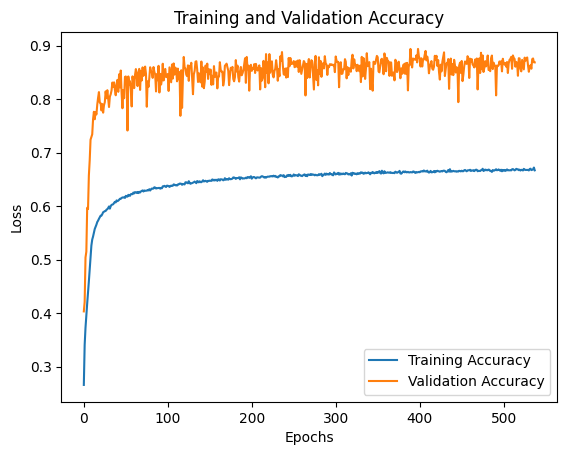

In [17]:
# Plot the training and validation accuracy
plt.plot(history.history['acc'], label='Training Accuracy')
plt.plot(history.history['val_acc'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

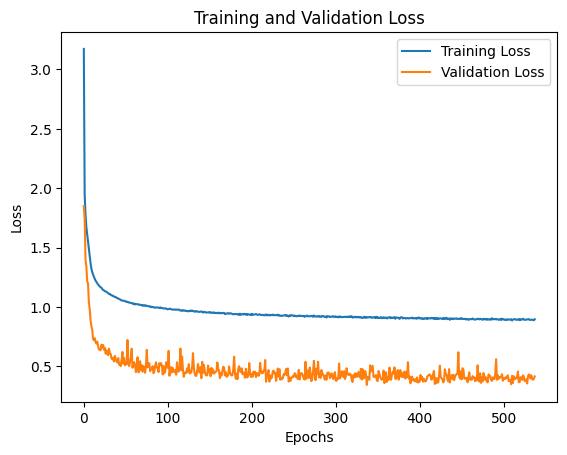

In [18]:
# Plot the training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

#### Performance evaluation of the best model

In [19]:
best_model = keras.models.load_model('../models/ffnn_checkpoint.h5')

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [20]:
loss, accuracy = best_model.evaluate(X_test, y_test_onehot)
loss, accuracy

14000/14000 [==============================] - 0s 8us/sample - loss: 0.3423 - acc: 0.8871


(0.34232682950156074, 0.88714284)

#### More metrics

In [21]:
model_predictions = best_model.predict(X_test)
y_pred = np.argmax(model_predictions, axis=1)

In [22]:
y_pred.shape, y_test.shape

((14000,), (14000,))

In [23]:
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='macro')
roc_auc = roc_auc_score(y_test_onehot, model_predictions, average='macro', multi_class='ovr')
print(f'Accuracy: {accuracy}, F1: {f1}, ROC-AUC:{roc_auc}')

Accuracy: 0.8871428571428571, F1: 0.8489973016297718, ROC-AUC:0.9955336059941357


In [24]:
test_df = pd.DataFrame()
test_df['y_actual'] = y_test
test_df['y_pred'] = y_pred
acc, f1, roc_auc =  utils.get_metrics(test_df)
acc, f1, roc_auc

(88.71428571428571, 84.89973016297718, 92.45703203191691)

###### 